In [121]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using JLD
using Statistics
using LaTeXStrings


Consider the problem of recovering $x\in\mathbb{R}^n$ from noisy signed compressive measurements of the form

$$y = \text{sign}(Ax) + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise and $A \in \mathbb{R}^{m\times n}$ is a known sensing matrix. We assume the unknown signal $x$ lives in the range of known a generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn)-1bit:

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}A^{\top}\left(\text{sign}(AG(x^k)) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions.

We now list the function that are relavant to the computation of the esitmate using the PLUGIn-1bit algorithm. The following function can be used to output an estimate $x^{k+1}$ from PLUGIn-1bit from another estimate $x^k$ of the ground truth.

In [2]:
# output the plugin Iterate
function PLUGIN_1bitCS_estimate(A, G, W, y, z, stepsize)
    d = W'*A'* (sign.(A * G(z)) - y )
    return z - stepsize * d
end

PLUGIN_1bitCS_estimate (generic function with 1 method)

One advantage of PLUGIn algorithm in general is that it allows us to pre-multiply the weight matrices. The following function is used to compute $A_d\cdot A_{d-1}\cdots A_1$ given a generative model $G$. It also normalizes each weight matrix w.r.t. its top singular value.

In [3]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

The following function can be used to create a general generative function with number of nodes in each layer specified. The entries of the weight matrices are initialized to be normalized random normal.

In [4]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

create_network (generic function with 1 method)

The following function can be used to estimate the ground truth from signed compressive measurements using the PLUGIn-1bit algorithm:

In [85]:
function PLUGIn_onebitCS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    
    (_, z_dim) = size(Flux.params(G[1])[1]);
    (m, _) = size(A)
    W = I(z_dim)
  
    #normalize the weights of the network
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
  
    z = randn(z_dim)
    iter = 1
    succ_error = 1
  
    while iter <= max_iter && succ_error > tolerance
      # d gives the PLUGIn direction
      d = sign.(A * G(z)) - y
      d = W'*A'* d
      z -= stepsize * d
      succ_error = norm(stepsize * d)
      if iter % out_toggle == 0  
          println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
      end
      iter += 1
    end
    println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
  
    return z
  end

PLUGIn_onebitCS (generic function with 2 methods)

In the first experiment, we want to examine the convergence rate of the PLUGIn-bit algorithm as a function of the number of measurement. Define the recovery error  as:
$$\text{recovery error, $\delta$} := \left\| \tfrac{x^{\natural}}{\|x^\natural\|} - \tfrac{x^*}{\|x^*\|} \right\|,$$
where $x^\natural$ is the recovered estimate of ground truth $x^*$. We hope to see a error decay as $\delta \sim \tfrac{1}{m^\alpha}$ for some $\alpha \in (0,1)$.


The following code segment is used to generate the relationship betwen $\delta$ and $m$.

**WARNING** The following code segment can take a while to complete as it will compute the recovery error multiple times for various measurement levels. To see a instance of the result, skip to the next code segment that loads the reults of a pre-compiled instance.

In [ ]:
net_param = [5, 200, 750]
x_dim  = net_param[length(net_param)]
z_dim = net_param[1]

G = create_network(net_param)
    
stepsize = 1
max_iter = 2000
tolerance = 1e-7

W = normalized_weight_product(G)
m_list = 750:1000:50000
trials = 10
recov_error_matrix = zeros(length(m_list))

for trial in 1:trials
    recov_error = []
    z = randn(z_dim)

    for m in m_list
        A = randn(m, x_dim)/sqrt(m)
        y = sign.(A*G(z))
        z_est = zeros(z_dim)
        iter = 1
        succ_error = 1

        while iter <= max_iter && succ_error > tolerance
            z_old = z_est
            z_est = PLUGIN_1bitCS_estimate(A, G, W, y, z_est, stepsize)
            succ_error = norm(z_old - z_est, 2)
            iter += 1
        end
        push!(recov_error, norm(z/norm(z) - z_est/norm(z_est)))
    end
    recov_error_matrix = hcat(recov_error_matrix, recov_error)

end

# change the filename before running this code if you wish to save the results

# M = recov_error_matrix[:,2:end]
# save("result/error_1.jld", "error", M, "measurement", m_list, "trials", trials)

We can now show the relationship between recovery error and measurement level. Note that the plot is in log scale and so we hope to see a linear curve. In this plot, the generative function $G$ a 2-layer deep random neural network and satisfies $5\rightarrow 200\rightarrow 750$. The number of measurment ranges is uniformly sampled in the interval [750, 30000]. For each measurment, we report the average of 10 trials. 

Note that the relationship between recovery error and measurement level "looks" linear (in log scale).

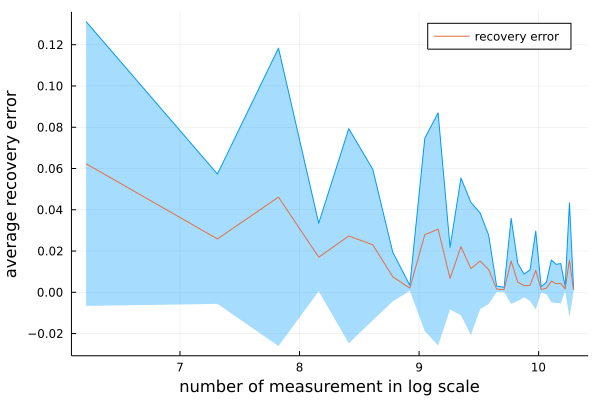

In [6]:
M2 = load("result/error.jld", "error")
m_list = load("result/error.jld", "measurement")

average_recov = mean(M2, dims=2)
std_recov = std(M2, dims=2)
plot(log.(m_list), average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
plot!(log.(m_list), average_recov, label = "recovery error", xlabel = "number of measurement in log scale", ylabel = "average recovery error")


We now define a function that quantizes the input into $2k-1$ bits. For an input $x$ with entries bounded, $k$-quantized version of $x$ is given by:

$$ Q_k(x) = \frac{1}{k-1}\text{Round}((k-1)x).$$

The recovery problem we consider is to recover a fixed vector $z$ from $k$-quantized measurements of the form

$$ y = Q_k(AG(z)) + \epsilon,$$

where $G:\mathbb{R}^k\rightarrow \mathbb{R}^n$ is a known generator and $A\in\mathbb{R}^{m\times n}$ is the compressive measurement. We implement a version of PLUGIn to recover $z$.

In [19]:
function k_quantized(z,k)
    return round.((k-1)*z)/(k-1)
end

# output the plugin Iterate
function PLUGIN_kbitCS_estimate(A, G, W, y, z, k, stepsize)
    d = W'*A'* (k_quantized(A * G(z), k) - y )
    return z - stepsize * d
end

PLUGIN_kbitCS_estimate (generic function with 1 method)

Below we examine the recovery of a fixed latent signal $z$ in the noiseless case from $k$-quantized measurement. We take $k$ in the range $[3,10]$. Comparision to One-bit is made.

In [123]:
net_param = [5, 200, 750]
x_dim  = net_param[length(net_param)]
z_dim = net_param[1]

G = create_network(net_param)
W = normalized_weight_product(G)

stepsize = 1
max_iter = 2000
tolerance = 1e-7
m = 10000

trials = 10
k_max = 10

recov_error_matrix_kquant = zeros(k_max - 2)
recov_error_onebit = []

for trial in 1:trials
    recov_error_kquant = []
    A = randn(m, x_dim)/sqrt(m)
    z = randn(5)*sqrt(m/20)
    y_onebit = sign.(A*G(z))


    for k in 3:k_max
        y_kquant = k_quantized(A*G(z), k)
        z_est = zeros(z_dim)
        iter = 1
        succ_error = 1

        while iter <= max_iter && succ_error > tolerance
            z_old = z_est
            z_est = PLUGIN_kbitCS_estimate(A, G, W, y_kquant, z_est, k, stepsize)
            succ_error = norm(z_old - z_est, 2)
            iter += 1
        end
        push!(recov_error_kquant, norm(z/norm(z) - z_est/norm(z_est)))
    end
    recov_error_matrix_kquant = hcat(recov_error_matrix_kquant, recov_error_kquant)

    z_est = zeros(z_dim)
    iter = 1
    succ_error = 1
    while iter <= max_iter && succ_error > tolerance
        z_old = z_est
        z_est = PLUGIN_1bitCS_estimate(A, G, W, y_onebit, z_est, stepsize)
        succ_error = norm(z_old - z_est, 2)
        iter += 1
    end
    push!(recov_error_onebit, norm(z/norm(z) - z_est/norm(z_est)))

end


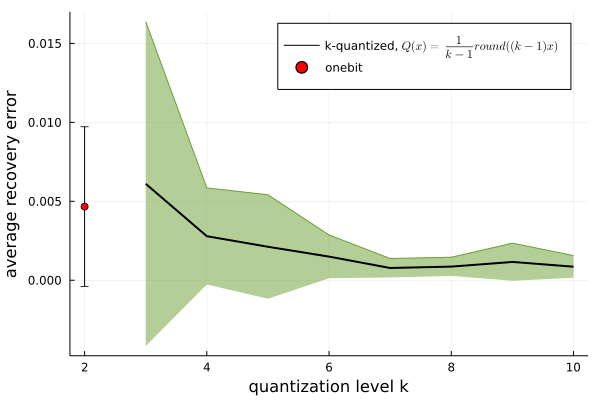

In [124]:
average_recov = mean(recov_error_matrix_kquant, dims=2)
std_recov = std(recov_error_matrix_kquant, dims=2)
plot(3:k_max, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
plot!(3:k_max, average_recov, label = "k-quantized, \$ Q(x) = \\frac{1}{k-1} round((k-1)x)\$", xlabel = "quantization level k", ylabel = "average recovery error", linewidth = 2, c =:black)

average_recov_onebit = mean(recov_error_onebit)
std_recov_onebit = std(recov_error_onebit)

plot!([2],[average_recov_onebit],yerr = [std_recov_onebit],seriestype = :scatter, label = "onebit", c = :red)

In [82]:
    
G = Chain(
    Dense(5, 75, relu, bias = false; initW =(out,in) ->  randn(75, 5)/sqrt(75)),
    Dense(75, 100, relu, bias = false; initW =(out,in) -> randn(75, 75)/sqrt(75)),
    Dense(75, 150, relu, bias = false; initW =(out,in) -> randn(150, 75)/sqrt(150))
)
W = normalized_weight_product(G)


m = 50000; A = randn(m, 150)/sqrt(m)
k = 2
z = randn(5)*sqrt(m/20)
y = k_quantized(A*G(z), k) 

stepsize = 1
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
lambda = 100

z_est = randn(5)*sqrt(m/20)
for i in 1:max_iter
    z_est = PLUGIN_kbitCS_estimate(A, G, W, y, z_est, k, stepsize)
end
recov_error = norm(z/norm(z) - z_est/norm(z_est))
recon_error = norm(G(z) - G(z_est))
println("recovery error: $recov_error, reconstruction error: $recon_error")

y_onebit = sign.(A*G(z))
z_rec_onebit = PLUGIn_onebitCS(G,y_onebit,A, max_iter, stepsize, tolerance, lambda, out_toggle)
recov_error = norm(z/norm(z) - z_rec_onebit/norm(z_rec_onebit))
recon_error = norm(G(z) - G(z_rec_onebit))
println("recovery error: $recov_error, reconstruction error: $recon_error")

recovery error: 0.19007817994943682, reconstruction error: 6.329429103204856
====> In quasi-gradient: Iteration: 1000 Successive error: 0.17785409812077413
====> In quasi-gradient: Iteration: 2000 Successive error: 0.17550582366666967
====> In quasi-gradient: Iteration: 3000 Successive error: 0.13868696521588988
====> In quasi-gradient: Iteration: 4000 Successive error: 0.15794569615022094
====> In quasi-gradient: Iteration: 5000 Successive error: 0.15160613906223666
====> In quasi-gradient: Iteration: 6000 Successive error: 0.13765380042603134
====> In quasi-gradient: Iteration: 7000 Successive error: 0.13111567085625941
====> In quasi-gradient: Iteration: 8000 Successive error: 0.1439659962157021
====> In quasi-gradient: Iteration: 9000 Successive error: 0.14229958718116212
====> In quasi-gradient: Iteration: 10000 Successive error: 0.13855474509063476
====> In quasi-gradient: Iteration: 10001 Successive error: 0.13855474509063476
recovery error: 0.0034770394024046954, reconstruction

In [84]:
y

y_onebit

50000-element Vector{Float64}:
  1.0
 -1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
  ⋮
  1.0
  1.0
  1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0

The following code segment can be used to estimate the ground truth using the function PLUGIn_onebitCS.

In [78]:
    
G = Chain(
    Dense(5, 75, relu, bias = false; initW =(out,in) ->  randn(75, 5)/sqrt(75)),
    Dense(75, 100, relu, bias = false; initW =(out,in) -> randn(75, 75)/sqrt(75)),
    Dense(75, 150, relu, bias = false; initW =(out,in) -> randn(150, 75)/sqrt(150))
)


z = randn(5)
m = 50000; A = randn(m, 150)/sqrt(m)
y = sign.(A*G(z)) + 1e-14 * randn(m)

stepsize = 1
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
lambda = 100
z_rec = PLUGIn_onebitCS(G,y,A, max_iter, stepsize, tolerance, lambda, out_toggle)
recov_error = norm(z/norm(z) - z_rec/norm(z_rec))
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")

====> In quasi-gradient: Iteration: 1000 Successive error: 8.723640499839139
====> In quasi-gradient: Iteration: 2000 Successive error: 8.802589258303522
====> In quasi-gradient: Iteration: 3000 Successive error: 8.745261002348933
====> In quasi-gradient: Iteration: 4000 Successive error: 8.73434792204743
====> In quasi-gradient: Iteration: 5000 Successive error: 8.859455948664392
====> In quasi-gradient: Iteration: 6000 Successive error: 8.743959493635444
====> In quasi-gradient: Iteration: 7000 Successive error: 8.742841571231438
====> In quasi-gradient: Iteration: 8000 Successive error: 8.817225622511355
====> In quasi-gradient: Iteration: 9000 Successive error: 8.801512427727083
====> In quasi-gradient: Iteration: 10000 Successive error: 8.913394203896397
====> In quasi-gradient: Iteration: 10001 Successive error: 8.913394203896397
recovery error: 0.33608366783962745, reconstruction error: 5.220944556997646


The following code segment is an attempt to implement another algorithm for 1-bit CS with generative model introduced in the paper:
https://arxiv.org/pdf/1908.05368.pdf 

This still needs to be debugged.

In [ ]:
#using Zygote to solve ERM for a synthetic problem


G = Chain(
    Dense(5, 75, relu, bias = false; initW =(out,in) ->  randn(75, 5)/sqrt(75)),
    Dense(75, 75, relu, bias = false; initW =(out,in) -> randn(75, 75)/sqrt(75)),
    Dense(75, 150, relu, bias = false; initW =(out,in) -> randn(150, 75)/sqrt(150))
)


z = randn(5)
m = 5000; A = randn(m, 150)/sqrt(m)
y = sign.(A*G(z)) + 1e-14 * randn(m)

stepsize = .1
tolerance = 1e-7
max_iter = 1000
out_toggle = 1000
lambda = 10

z_rec = randn(5)


for i in 1:max_iter

    d = gradient(z_rec -> norm(G(z_rec),2)^2 - 2*lambda * y'*(A * G(z_rec))/m, z_rec)[1]
    z_rec -= stepsize * d
    succ_error = norm(stepsize * d)
    if i % out_toggle == 0  
        println("====> In quasi-gradient: Iteration: $i Successive error: $succ_error")
    end
end


# z_rec = PLUGIn_onebitCS(G,y,A, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z/norm(z) - z_rec/norm(z_rec))
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")